# Определение стоимости автомобилей

Необходимо построить модель для определения рыночной стоимости автомобиля на основе данных о технических характеристиках, комплектации и цены. Важно обратить внимание на качество, скорость предсказания и время обучения. В качестве оценки качества использовать Root mean squared error (RMSE).

## Подготовка данных

In [1]:
from urllib.request import urlretrieve
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime
import time
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor

Извлекаем данные из файла

In [2]:
df = pd.read_csv('datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Рассмотрим первые 10 записей

In [4]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


### Повторы

Посмотрим на повторяющиеся анкеты, исключим поля с датами

In [5]:
df.duplicated().sum()

4

In [6]:
df[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'NumberOfPictures', 'PostalCode']].duplicated(keep='last').sum()/len(df)

0.06019996105754172

Имеется 6% повторных записей. Это повторно созданные анкеты. Удалим их, оставив последние из них (хотя это не существенно).

In [7]:
df = df.drop_duplicates(subset=['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'NumberOfPictures', 'PostalCode'], keep='last')

In [8]:
len(df)

333036

### Типы данных

Приведём даты к типу datetime

In [9]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d ')

In [10]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d ')

In [11]:
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d ')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333036 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        333036 non-null  datetime64[ns]
 1   Price              333036 non-null  int64         
 2   VehicleType        296896 non-null  object        
 3   RegistrationYear   333036 non-null  int64         
 4   Gearbox            314021 non-null  object        
 5   Power              333036 non-null  int64         
 6   Model              314013 non-null  object        
 7   Kilometer          333036 non-null  int64         
 8   RegistrationMonth  333036 non-null  int64         
 9   FuelType           301134 non-null  object        
 10  Brand              333036 non-null  object        
 11  NotRepaired        264973 non-null  object        
 12  DateCreated        333036 non-null  datetime64[ns]
 13  NumberOfPictures   333036 non-null  int64   

### Исследование данных

#### Целевой признак

Рассмотрим целевой признак

In [13]:
df['Price'].describe()

count    333036.000000
mean       4378.277586
std        4502.534823
min           0.000000
25%        1000.000000
50%        2699.000000
75%        6299.250000
max       20000.000000
Name: Price, dtype: float64

<AxesSubplot:>

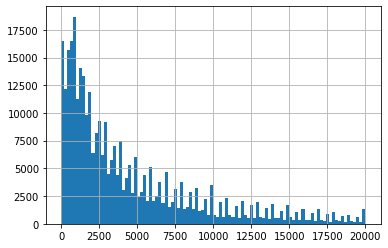

In [14]:
df['Price'].hist(bins=100)

Посчитаем количество записей с нулевой ценой

In [15]:
len(df[df['Price'] == 0])

10013

In [16]:
df[df['Price'] == 0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20,0,37520,2016-04-07 02:45:22
154,2016-03-22 16:37:59,0,NaN,2006,NaN,0,other,5000,0,NaN,fiat,NaN,2016-03-22,0,44867,2016-04-06 06:17:56
231,2016-03-16 22:06:24,0,wagon,2001,manual,115,mondeo,150000,0,NaN,ford,NaN,2016-03-16,0,57627,2016-03-26 11:17:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10,0,22559,2016-03-12 23:46:32


Посмотрим на распределение количества записей для авто с ценой менее 1000

<AxesSubplot:>

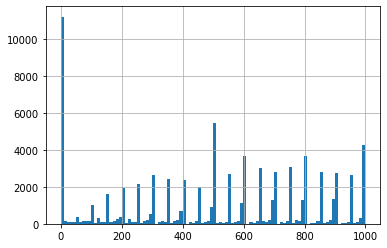

In [17]:
df[df['Price'] < 1000]['Price'].hist(bins=100)

Доля авто с нулевой ценой

In [18]:
len(df[df['Price'] == 0])/len(df)

0.030065818710289578

Предложения с нулевой ценой на сервисе продаж - это странно. Такие данные нам будут мешать. Удалим их. Это 3% всех данных.

In [19]:
df = df.drop(df[df['Price'] == 0].index)

In [20]:
len(df[df['Price'] == 0])

0

#### Категории

'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'    

Заполним пропуски в категориях значением ***undefined***, так как скорее всего не все возможные категории имеются в сервисе, или затруднительно выбрать из имеющихся, либо пользователь намеренно не уточняет.

**VehicleType — тип автомобильного кузова**

In [21]:
df['VehicleType'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

Заполним пропуски значением ***undefined***

In [22]:
df['VehicleType'] = df['VehicleType'].fillna('undefined')

In [23]:
df['VehicleType'].value_counts()

sedan          83806
small          73159
wagon          59512
undefined      32592
bus            26658
convertible    18598
coupe          14791
suv            10912
other           2995
Name: VehicleType, dtype: int64

**Gearbox — тип коробки передач**

In [24]:
df['Gearbox'].sort_values().unique()

array(['auto', 'manual', nan], dtype=object)

Заполним пропуски значением ***undefined***

In [25]:
df['Gearbox'] = df['Gearbox'].fillna('undefined')

In [26]:
df['Gearbox'].value_counts()

manual       245845
auto          60495
undefined     16683
Name: Gearbox, dtype: int64

**FuelType — тип топлива**

In [27]:
df['FuelType'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

Заполним пропуски значением ***undefined***

In [28]:
df['FuelType'] = df['FuelType'].fillna('undefined')

In [29]:
df['FuelType'].value_counts()

petrol       198044
gasoline      90523
undefined     28640
lpg            4821
cng             520
hybrid          222
other           166
electric         87
Name: FuelType, dtype: int64

**Brand — марка автомобиля**

In [30]:
df['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

**Model — модель автомобиля**

In [31]:
df['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Заполним пропуски значением ***undefined***

In [32]:
df['Model'] = df['Model'].fillna('undefined')

In [33]:
df['Model'].value_counts()

golf                  26546
other                 22683
3er                   17996
undefined             16953
polo                  11892
                      ...  
kalina                    8
rangerover                4
serie_3                   3
serie_1                   1
range_rover_evoque        1
Name: Model, Length: 251, dtype: int64

**NotRepaired — была машина в ремонте или нет**

In [34]:
df['NotRepaired'].sort_values().unique()

array(['no', 'yes', nan], dtype=object)

Заполним пропуски в категориях значением ***undefined***

In [35]:
df['NotRepaired'] = df['NotRepaired'].fillna('undefined')

In [36]:
df['NotRepaired'].value_counts()

no           227215
undefined     63080
yes           32728
Name: NotRepaired, dtype: int64

#### Мощность двигателя

In [37]:
df['Power'].describe()

count    323023.000000
mean        110.646381
std         192.519445
min           0.000000
25%          69.000000
50%         105.000000
75%         142.000000
max       20000.000000
Name: Power, dtype: float64

<AxesSubplot:>

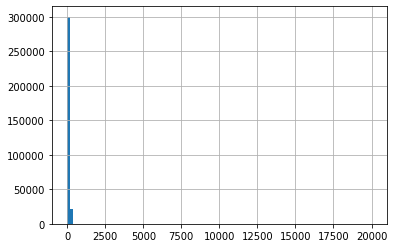

In [38]:
df['Power'].hist(bins=100)

Мощность двигателя имеет много нулевых значений, а также огромный разброс до неадекватных значений > 700 л. с.
Например, мощность двигателей audi до 544 л. с., а bmw 635 л. с. 
https://www.audi.ru/ru/web/ru/innovations/new-engine-power-designations.html
https://mirbmw.ru/samye-moshhnye-dvigateli-bmw/

<AxesSubplot:>

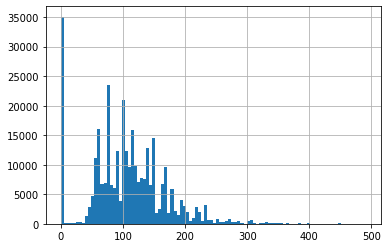

In [39]:
df[df['Power']<500]['Power'].hist(bins=100)

Двигатель машины не может иметь нулевую мощность, не понятно по каким причинам эти данные не указаны. Возможно, характеристики не были под рукой, либо, возможно, в документации указаны в других единицах, или не указаны. Чтобы обеспечить адекватность количественного признака, заменим нулевое значение на неопределённое.

Количество записей авто с нулевой мощностью двигателя 

In [40]:
len(df[df['Power']==0])

34999

Доля записей авто с нулевой мощностью двигателя

In [41]:
len(df[df['Power']==0])/len(df)

0.1083483219461153

In [42]:
# df['Power'] = df['Power'].astype('Int64')

Поставим пустое значение вместо "0"

In [43]:
df.loc[(df['Power']==0), 'Power'] = np.nan

In [44]:
len(df[df['Power']==0])

0

In [45]:
df[df['Power']>500][['Brand', 'Model', 'Power']].head()

,Brand,Model,Power
1816,toyota,corolla,1398.0
4060,mitsubishi,colt,953.0
5328,opel,astra,1001.0
6504,fiat,punto,771.0
6637,opel,corsa,603.0


Выборочная проверка показала, что многие значения больше 500 не характерны для значений штатных двигателей по данным из открытых источников. Некоторые значения (более 1000) совпадают с объемом двигателя. 

Отбросим неадекватные большие и малые значения мощности. В качестве критерия, отбросим справа и слева хвосты распределения в 0.5%

In [46]:
min_power = df['Power'].quantile(0.005) 

In [47]:
max_power = df['Power'].quantile(0.995) 

In [48]:
(min_power, max_power)

(40.0, 340.0)

In [49]:
df.loc[(df['Power']>max_power), 'Power'] = np.nan

In [50]:
df.loc[(df['Power']<min_power), 'Power'] = np.nan

<AxesSubplot:>

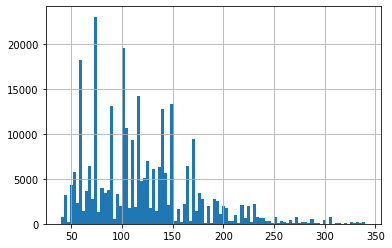

In [51]:
df['Power'].hist(bins=100)

**Пробег**

In [52]:
df['Kilometer'].describe()

count    323023.000000
mean     128445.745349
std       37505.924140
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

<AxesSubplot:>

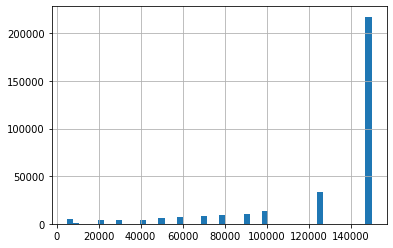

In [53]:
df['Kilometer'].hist(bins=50)

Пробег имеет ступенчатый характер значений. Аномальных значений не выявлено.

In [54]:
df['NumberOfPictures'].describe()

count    323023.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

Абсолютно неинформативный столбец. Удалим

In [55]:
df.drop(columns=['NumberOfPictures'], inplace=True)

#### Время активности

Вычислим время активности анкеты до изменения в системе

In [56]:
df['ActivityDays'] = (df['LastSeen'] - df['DateCreated']).dt.days

<AxesSubplot:>

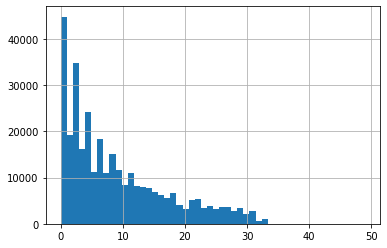

In [57]:
df[df['ActivityDays'] <50]['ActivityDays'].hist(bins=50)

In [58]:
df['ActivityDays'].describe()

count    323023.000000
mean          8.797401
std           8.680096
min           0.000000
25%           2.000000
50%           6.000000
75%          14.000000
max         759.000000
Name: ActivityDays, dtype: float64

#### Возраст автомобиля

In [59]:
df['RegistrationYear'].describe()

count    323023.000000
mean       2004.076923
std          80.061915
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

<AxesSubplot:>

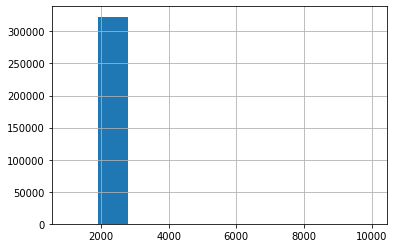

In [60]:
df['RegistrationYear'].hist()

Исключим будущие годы регистрации

In [61]:
df[df['RegistrationYear']> df['DateCreated'].dt.year]['RegistrationYear'].sort_values().unique()

array([2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600,
       5900, 5911, 6000, 6500, 7000, 7100, 7800, 8000, 8200, 8500, 8888,
       9000, 9450, 9999], dtype=int64)

In [62]:
len(df[(df['RegistrationYear'] > df['DateCreated'].dt.year)])

13193

In [63]:
# df['RegistrationYear'] = df['RegistrationYear'].astype('Int64')

In [64]:
df.loc[(df['RegistrationYear'] > df['DateCreated'].dt.year), 'RegistrationYear'] = np.nan

Исключим неадекватные годы регистрации в прошлом до границы 20 века.

In [65]:
df[df['RegistrationYear']<1900]['RegistrationYear'].sort_values().unique()

array([1000., 1001., 1039., 1111., 1234., 1255., 1300., 1400., 1500.,
       1600., 1602., 1800.])

In [66]:
df.loc[(df['RegistrationYear'] < 1900), 'RegistrationYear'] = np.nan

<AxesSubplot:>

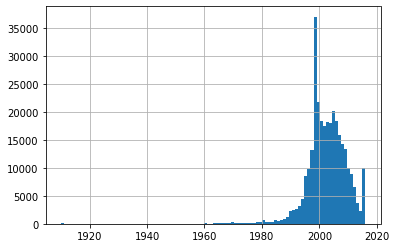

In [67]:
df['RegistrationYear'].hist(bins=100)

In [68]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'PostalCode', 'LastSeen', 'ActivityDays'],
      dtype='object')

In [69]:
df['RegistrationMonth'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

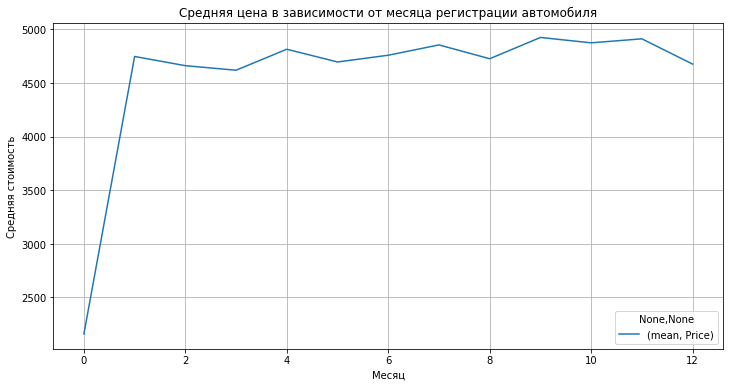

In [70]:
ax = pd.pivot_table(df, values=['Price'], index=['RegistrationMonth'], aggfunc=['mean']).plot(figsize=(12,6), grid=True, 
   title='Средняя цена в зависимости от месяца регистрации автомобиля')
ax.set_xlabel("Месяц")
ax.set_ylabel("Средняя стоимость")
plt.show()

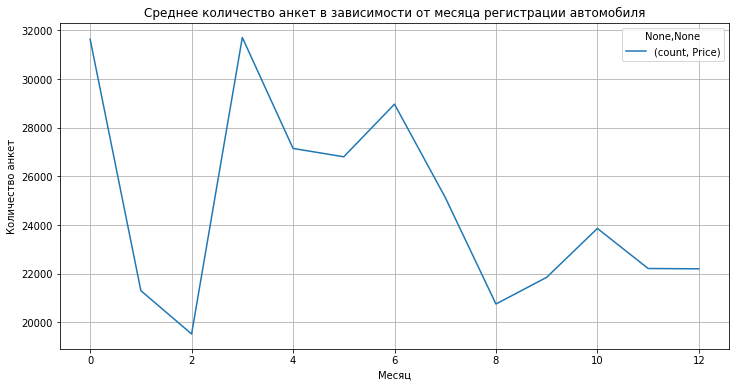

In [71]:
ax = pd.pivot_table(df, values=['Price'], index=['RegistrationMonth'], aggfunc=['count']).plot(figsize=(12,6), grid=True, 
   title='Среднее количество анкет в зависимости от месяца регистрации автомобиля')
ax.set_xlabel("Месяц")
ax.set_ylabel("Количество анкет")
plt.show()

Средняя цена мало меняется в зависимости от месяца, лишь изменяется количество анкет. Удалим этот столбец и сократим время обучения.

In [72]:
df.drop(columns=['RegistrationMonth'], inplace=True)

### Удаление столбцов

Удалим столбец с почтовым кодом. Он никак не характеризует автомобиль и анкету.

In [73]:
df.drop(columns=['PostalCode'], inplace=True)

In [74]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'NotRepaired',
       'DateCreated', 'LastSeen', 'ActivityDays'],
      dtype='object')

Удалим даты анкет. Возможно полезный признак **время размещения анкеты** мы уже вынесли отдельно.

In [75]:
df.drop(columns=['DateCrawled'], inplace=True)

In [76]:
df.drop(columns=['DateCreated'], inplace=True)

In [77]:
df.drop(columns=['LastSeen'], inplace=True)

Посмотрим, какие признаки у нас остались

In [78]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,ActivityDays
0,480,undefined,1993.0,manual,NaN,golf,150000,petrol,volkswagen,undefined,14
1,18300,coupe,2011.0,manual,190.0,undefined,125000,gasoline,audi,yes,14
2,9800,suv,2004.0,auto,163.0,grand,125000,gasoline,jeep,undefined,22
3,1500,small,2001.0,manual,75.0,golf,150000,petrol,volkswagen,no,0
4,3600,small,2008.0,manual,69.0,fabia,90000,gasoline,skoda,no,6


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323023 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             323023 non-null  int64  
 1   VehicleType       323023 non-null  object 
 2   RegistrationYear  309779 non-null  float64
 3   Gearbox           323023 non-null  object 
 4   Power             285297 non-null  float64
 5   Model             323023 non-null  object 
 6   Kilometer         323023 non-null  int64  
 7   FuelType          323023 non-null  object 
 8   Brand             323023 non-null  object 
 9   NotRepaired       323023 non-null  object 
 10  ActivityDays      323023 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 29.6+ MB


### Пропущенные значения

Для работы с простыми моделями нам придётся избавиться от пропусков. 

In [80]:
len(df[(df['Power'].isnull()==True) | (df['RegistrationYear'].isnull()==True)])

47485

Так как Power и RegistrationYear наиболее значимые признаки для предсказания цены, придётся пойти на серьёзную жертву в данных. Мы не можем поставить в них средние или медианные значения, так как это исказит данные, а в задаче важна точность.

In [81]:
len(df)

323023

In [82]:
df = df.dropna()

In [83]:
len(df)

275538

### Разделение данных

Столбец целевого признака

In [84]:
target_list = ['Price']

Столбцы признаков

In [85]:
features_list = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 
                 'Kilometer', 'FuelType', 'Brand', 'NotRepaired', 'ActivityDays']

Категориальные признаки

In [86]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

Числовые признаки

In [87]:
num_features = ['RegistrationYear', 'Power', 'Kilometer', 'ActivityDays']

Разделим данные на обучающую, валидационную и тестовую выборки

In [88]:
features_train, features_valid, target_train, target_valid = train_test_split(df[features_list], df[target_list], test_size=0.4, random_state=42)

In [89]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=42)

In [90]:
len(df)

275538

In [91]:
len(features_train) + len(features_valid) + len(features_test)

275538

### Вывод

- Данные содержали неполные дубликаты (без учёта значений дат), которые были удалены.
- Удалены строки в даннных с нулевым целевым признаком.
- В количественных признаках выбросы и неадекватные значения заменены на неопределённые.
- В категориальных признаках пустые значения заменены на undefined.
- На основе дат расчитан дополнительный количественный признак.
- Удалены некоторые столбцы как бесполезные для обучения модели.
- Подготовлены выборки для обучения моделей.

## Обучение моделей

Объявим список для сбора данных об обучаемых моделях

In [92]:
models_log = []

In [93]:
def draw_best_features(features_names, feature_importance, feature_importance_limit=0):
    df_features = pd.DataFrame(data = {'feature_name': features_names, 'importance': feature_importance})
    df_features = df_features.sort_values(by='importance', ascending=False)
    if feature_importance_limit > 0:
        df_features = df_features[df_features['importance'] > feature_importance_limit]

    fig, ax = plt.subplots(figsize=(12,6))
    df_features.set_index('feature_name', inplace=True)
    df_features.plot.bar(ax=ax)
    ax.grid()
    fig.tight_layout()    

Закодируем категории в числовые значения. У нас очень много категорий, чтобы избежать получения большого количества столбцов с используем OrdinalEncoder, и это позволит работать одновременно с разными моделями.

In [94]:
encoder = OrdinalEncoder(dtype=np.int64)

In [95]:
encoder.fit(df[cat_features])

OrdinalEncoder(dtype=<class 'numpy.int64'>)

In [96]:
features_train[cat_features] = encoder.transform(features_train[cat_features])
features_valid[cat_features] = encoder.transform(features_valid[cat_features])
features_test[cat_features] = encoder.transform(features_test[cat_features])

In [97]:
for feature in cat_features:
    features_train[feature] = pd.Series(features_train[feature], dtype="category")
    features_valid[feature] = pd.Series(features_valid[feature], dtype="category")
    features_test[feature] = pd.Series(features_test[feature], dtype="category")

In [98]:
features_train[cat_features]

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
299763,4,0,116,6,38,0
217297,5,1,83,6,24,0
328414,5,1,136,6,27,0
29949,5,1,73,7,11,1
105970,8,0,11,6,2,0
...,...,...,...,...,...,...
159411,1,1,149,6,27,0
334497,6,1,218,2,38,0
175054,5,1,8,6,25,0
194252,1,1,149,6,27,2


### Масштабирование признаков

In [99]:
scaler = StandardScaler()
scaler.fit(features_train[num_features])

StandardScaler()

In [100]:
features_train[num_features] = scaler.transform(features_train[num_features])
features_valid[num_features] = scaler.transform(features_valid[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

### LightGBM

In [101]:
lgb_train = lgb.Dataset(features_train, target_train, categorical_feature=cat_features, free_raw_data=False)
lgb_valid = lgb.Dataset(features_valid, target_valid, categorical_feature=cat_features, free_raw_data=False)

In [102]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.5,
    'early_stopping_rounds': 50,
    'num_boost_round': 1000,
    'seed': 42
}

In [103]:
start_time = datetime.now()

lgb_model = lgb.train(
    hyper_params, 
    train_set=lgb_train, 
    valid_sets=(lgb_train, lgb_valid),      
    verbose_eval=25)

lgb_model_learn_time = datetime.now() - start_time

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 165322, number of used features: 10
[LightGBM] [Info] Start training from score 4777.157662
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1541.52	valid_1's rmse: 1633.2
[50]	training's rmse: 1473.21	valid_1's rmse: 1611.03
[75]	training's rmse: 1428.22	valid_1's rmse: 1596.52
[100]	training's rmse: 1394.46	valid_1's rmse: 1587
[125]	training's rmse: 1358.49	valid_1's rmse: 1578.43
[150]	training's rmse: 1335.72	valid_1's rmse: 1576.82
[175]	training's rmse: 1317.95	valid_1's rmse: 1576.65
[200]	training's rmse: 1304.08	valid_1's rmse: 1576.82
Early stopping, best iteration is:
[160]	training's rmse: 1327.8	valid_1's rmse: 1574.26
Wall time: 1.74 s


Лучшая характеристика RMSE для модели

In [104]:
lgb_model_valid_score = lgb_model.best_score['valid_1']['rmse']
lgb_model_valid_score

1574.2618195338744

In [105]:
start_time = datetime.now()
lgb_model_test_score = mean_squared_error(target_test, lgb_model.predict(features_test)) ** 0.5
lgb_model_predict_time = datetime.now() - start_time

In [106]:
lgb_model_valid_score, lgb_model_test_score, lgb_model_learn_time.seconds, lgb_model_predict_time.seconds

(1574.2618195338744, 1570.326864422358, 1, 0)

Занесём данные в сводную таблицу по моделям

In [107]:
models_log.append([
    'LightGBM', 
    lgb_model_valid_score, 
    lgb_model_test_score, 
    lgb_model_learn_time.seconds, 
    lgb_model_predict_time.seconds,
    hyper_params
])


Посмотрим, какие признаки внесли больший вес в предсказание.

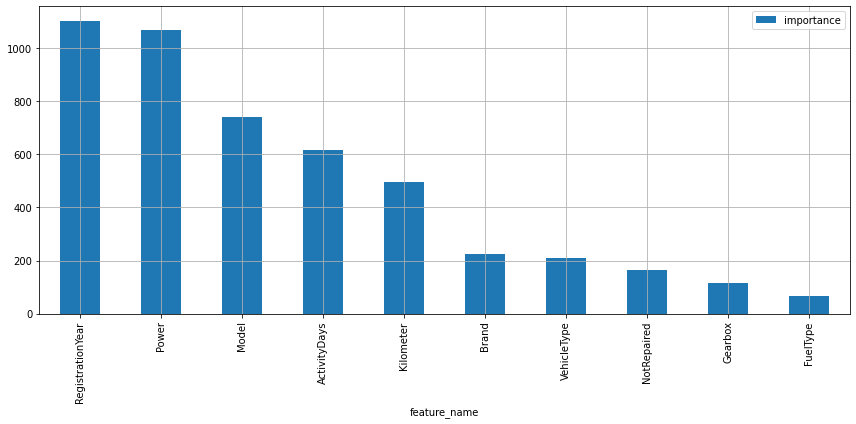

In [108]:
draw_best_features(features_list, lgb_model.feature_importance())

### Catboost

In [109]:
hyper_params = {
    'loss_function': 'RMSE',
    'learning_rate': 0.5,
    'num_boost_round': 1000,
    'leaf_estimation_iterations': 3,
    'depth': 5,
    'early_stopping_rounds': 50,
    'random_state': 42
}


In [110]:
cb_model = CatBoostRegressor(**hyper_params, thread_count=-1)

In [111]:
%%time
start_time = datetime.now()

cb_model.fit(features_train, target_train, cat_features=cat_features, eval_set=(features_valid, target_valid), 
             verbose=50)


cb_model_learn_time = datetime.now() - start_time

0:	learn: 3304.5595513	test: 3326.7048361	best: 3326.7048361 (0)	total: 314ms	remaining: 5m 13s
50:	learn: 1642.4533311	test: 1683.5271162	best: 1683.5271162 (50)	total: 6.5s	remaining: 2m 1s
100:	learn: 1571.5347070	test: 1639.9910011	best: 1639.9910011 (100)	total: 12.5s	remaining: 1m 51s
150:	learn: 1532.9351342	test: 1621.0110900	best: 1621.0110900 (150)	total: 19.2s	remaining: 1m 47s
200:	learn: 1505.9799738	test: 1604.9732158	best: 1604.8519046 (198)	total: 25.5s	remaining: 1m 41s
250:	learn: 1487.1491487	test: 1599.2029048	best: 1598.1095065 (242)	total: 31.7s	remaining: 1m 34s
300:	learn: 1470.5583509	test: 1592.3430576	best: 1592.3430576 (300)	total: 38.2s	remaining: 1m 28s
350:	learn: 1455.7659400	test: 1584.8662086	best: 1584.5111646 (349)	total: 43.8s	remaining: 1m 21s
400:	learn: 1443.9217989	test: 1581.6734178	best: 1581.5149890 (394)	total: 50.2s	remaining: 1m 15s
450:	learn: 1430.9257187	test: 1579.5926433	best: 1579.5926433 (450)	total: 56.3s	remaining: 1m 8s
500:	lear

Лучшая характеристика RMSE для модели

In [112]:
cb_model_valid_score = cb_model.best_score_['validation']['RMSE']

In [113]:
start_time = datetime.now()
cb_model_test_score = mean_squared_error(target_test, cb_model.predict(features_test)) ** 0.5
cb_model_predict_time = datetime.now() - start_time

In [114]:
cb_model_valid_score, cb_model_test_score, cb_model_learn_time.seconds, cb_model_predict_time.seconds

(1573.3669609753413, 1553.0453142758383, 75, 0)

Занесём данные в сводную таблицу по моделям

In [115]:
models_log.append([
    'Catboost', 
    cb_model_valid_score, 
    cb_model_test_score, 
    cb_model_learn_time.seconds,
    cb_model_predict_time.seconds,
    hyper_params
])


Посмотрим, какие признаки внесли больший вес в предсказание.

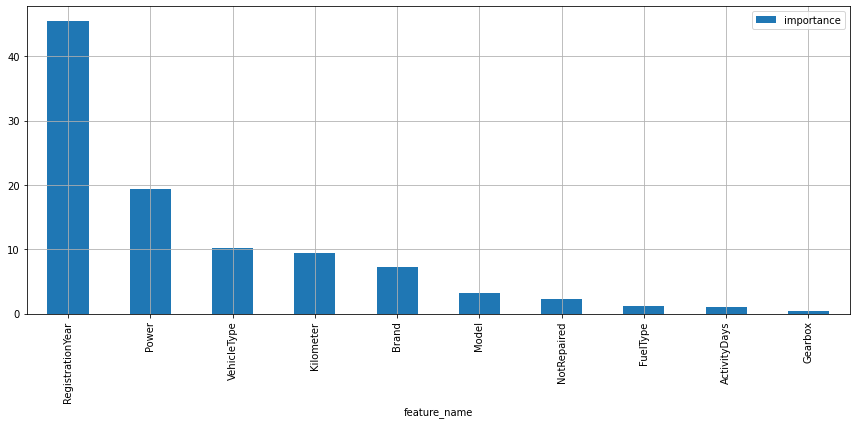

In [116]:
draw_best_features(features_list, cb_model.get_feature_importance())

### Другие модели

Воспользуемся рандомизированным подбором гиперпараметров для моделей.

In [117]:
hyper_params_set = {
    #'n_estimators':[x for x in range(10, 100, 10)],
    'n_neighbors': [4],
    'max_depth': [x for x in range(16, 32, 2)], 
    'leaf_size': [x for x in range(32, 64, 2)], 
    'min_samples_leaf': [x for x in range(1, 32, 2)],
    'min_samples_split': [x for x in range(2, 32, 2)],
}

In [118]:
%%time
for base_estimator in [DummyRegressor(), LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), KNeighborsRegressor()]:
    
    
    model_hyper_params = {}
    
    for key in hyper_params_set.keys():
        if key in base_estimator.get_params().keys():
            model_hyper_params[key] = hyper_params_set[key]    
            
            
    start_time = datetime.now()
    
    print(type(base_estimator).__name__, '...')
    
    clf = RandomizedSearchCV(base_estimator, model_hyper_params, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
    search = clf.fit(features_train, np.ravel(target_train))

    model_learn_time = datetime.now() - start_time

    print(abs(clf.best_score_) ** 0.5)
    print()
    
    start_time = datetime.now()

    model_test_score = mean_squared_error(target_test, clf.best_estimator_.predict(features_test)) ** 0.5

    model_predict_time = datetime.now() - start_time
    
    models_log.append([type(base_estimator).__name__, 
        abs(clf.best_score_) ** 0.5, 
        model_test_score, 
        model_learn_time.seconds,
        model_predict_time.seconds,
        search.best_params_
    ])   



DummyRegressor ...
4565.222990295302

LinearRegression ...
2857.265325406746

DecisionTreeRegressor ...
1810.0343404922953

RandomForestRegressor ...
1603.6623818182923

KNeighborsRegressor ...
1937.7537550970537

Wall time: 13min 51s


## Анализ моделей

In [119]:
models_df = pd.DataFrame(data=models_log, 
                         columns=['Модель', 'RMSE (валидационная выборка)', 'RMSE (тестовая выборка)', 'Время обучения, сек', 'Время предсказания, сек', 'Гиперпараметры'])

**Самые точные**

In [120]:
models_df.iloc[:, 0:5].sort_values(by=['RMSE (тестовая выборка)'], ascending=True)

,Модель,RMSE (валидационная выборка),RMSE (тестовая выборка),"Время обучения, сек","Время предсказания, сек"
1,Catboost,1573.366961,1553.045314,75,0
0,LightGBM,1574.261820,1570.326864,1,0
5,RandomForestRegressor,1603.662382,1618.348940,730,1
4,DecisionTreeRegressor,1810.034340,1810.542801,11,0
6,KNeighborsRegressor,1937.753755,1939.958562,79,3
3,LinearRegression,2857.265325,2884.097060,1,0
2,DummyRegressor,4565.222990,4606.543819,3,0


**Самые быстрые**

In [121]:
models_df.iloc[:, 0:5].sort_values(by=['Время обучения, сек'], ascending=True)

,Модель,RMSE (валидационная выборка),RMSE (тестовая выборка),"Время обучения, сек","Время предсказания, сек"
0,LightGBM,1574.261820,1570.326864,1,0
3,LinearRegression,2857.265325,2884.097060,1,0
2,DummyRegressor,4565.222990,4606.543819,3,0
4,DecisionTreeRegressor,1810.034340,1810.542801,11,0
1,Catboost,1573.366961,1553.045314,75,0
6,KNeighborsRegressor,1937.753755,1939.958562,79,3
5,RandomForestRegressor,1603.662382,1618.348940,730,1


**Лучшие**

In [122]:
models_df.iloc[:, 0:5].sort_values(by=['RMSE (тестовая выборка)'], ascending=True).head(3)

,Модель,RMSE (валидационная выборка),RMSE (тестовая выборка),"Время обучения, сек","Время предсказания, сек"
1,Catboost,1573.366961,1553.045314,75,0
0,LightGBM,1574.261820,1570.326864,1,0
5,RandomForestRegressor,1603.662382,1618.348940,730,1


Оценки качества всех моделей оказались лучше, чем у Dummy. Значит, мы работали в правильном направлении. Оценки качества для тестовой выборки подтверждают предварительные из валидационных выборок, различие небольшие. 

Самый **точный прогноз** нам удалось получить для ансамбля Catboost, но при этом он же оказался не самым быстрым. 

Следующим по качеству идёт гораздо **более быстрый** LightGBM. 

И третим по качеству, но средним в тройке по скорости признаем RandomForestRegressor.

В зависимости от конкретных задач рекомендуется выбор из этих трёх вариантов:
LightGBM, Catboost, RandomForestRegressor

**Время предсказания** почти всех моделей пренебрежимо малое. Заметное время предсказания показала модель KNeighborsRegressor (3 сек), эта модель не вошла в тройку лидеров.

Интересно, что большая часть категорий практически не вносит вклад во влияние на стоимость автомобиля. А наиболее весомыми являются:

- RegistrationYear — год регистрации автомобиля
- Power — мощность (л. с.)
- Kilometer — пробег (км)
- Brand — марка автомобиля
- Model — модель автомобиля
- и ActivityDays — длительность активности объявления

Этим параметрам стоит уделить больше внимания для заполнения.